# Analyse exploratoire des données : texte

# Import des packages : 

In [1]:
! pip install wordcloud
! pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, string
import seaborn as sns
from IPython.display import HTML
from wordcloud import WordCloud, STOPWORDS
import warnings
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

import contractions
from nltk.corpus import stopwords
import string

from nltk.stem import WordNetLemmatizer



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chargement des données : 

In [5]:
root_dir = '/content/drive/MyDrive/data'
train = pd.read_json(f"{root_dir}/{'train'}.jsonl", lines=True)
test = pd.read_json(f"{root_dir}/{'test'}.jsonl", lines=True)
dev = pd.read_json(f"{root_dir}/{'val'}.jsonl", lines=True)

# Affichage des données. : 

In [6]:
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


4 colonnes : id (identifiant du texte), img ( image correspondante pour le meme), label (binaire) et text (texte du meme) 

In [7]:
def get_df_name(df): #fonction pour le titre des plots
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def bar_plot(data_set): # fonction pour afficher la répartition haineux/non haineux par dataset
    sns.set(font_scale=1.4)
    label_dict = {0: 'non haineux', 1: 'haineux'}
    data_set_bis = data_set.copy(deep=True)
    data_set_bis['label'] = data_set_bis['label'].replace(label_dict)
    plot = data_set_bis['label'].value_counts().plot(kind="bar", figsize=(7, 6), rot=0)
    plt.title("Nombre de mèmes par catégorie pour le data set de " + get_df_name(data_set))
    plt.xlabel("Label du mème", labelpad=14)
    plt.ylabel("Nombre", labelpad=14)
    plt.xticks(fontsize=16)

    for i, val in enumerate(data_set['label'].value_counts().values):
        plot.text(i, val+1, str(val), fontsize=12, horizontalalignment='center')

    return plot

<Axes: title={'center': 'Nombre de mèmes par catégorie pour le data set de train'}, xlabel='Label du mème', ylabel='Nombre'>

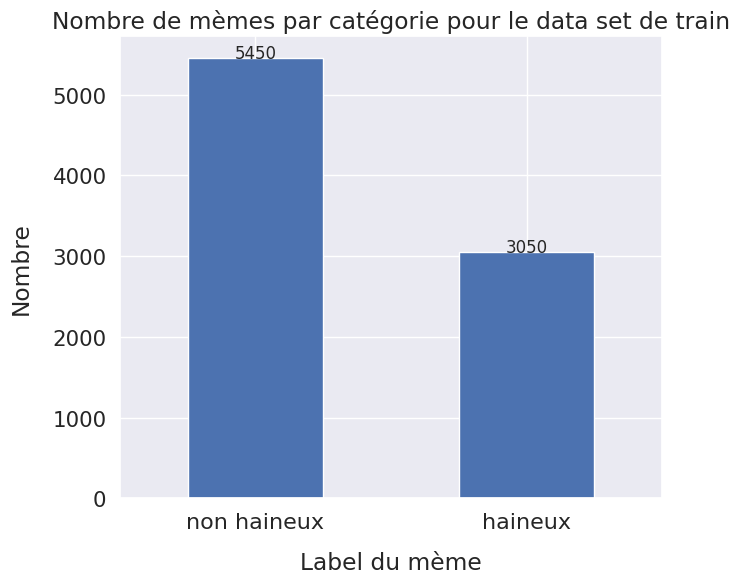

In [8]:
bar_plot(train)

<Axes: title={'center': 'Nombre de mèmes par catégorie pour le data set de dev'}, xlabel='Label du mème', ylabel='Nombre'>

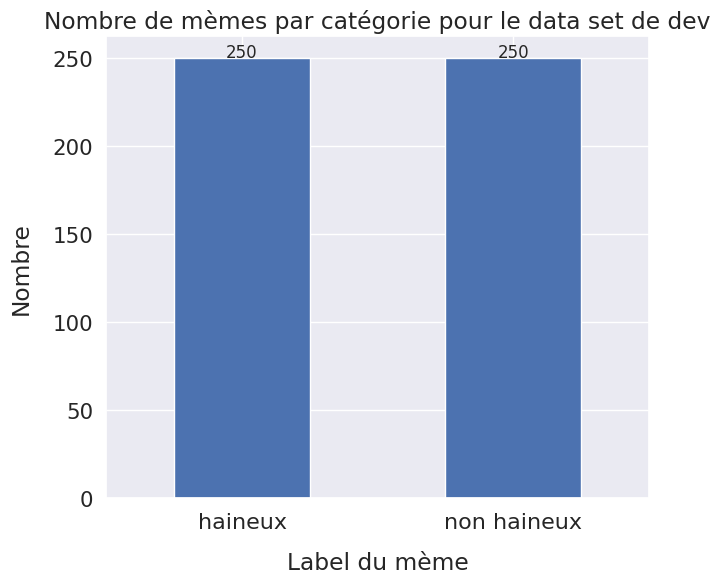

In [9]:
bar_plot(dev)

Le data set d'entraînement contient 8 500 memes : 3 050 memes avec le label 1 (haineux) contre 5 450 avec le label 0 (non haineux)




Le data set de développement contient 500 memes : 250 memes avec le label 1 (haineux) et 250 avec le label 0 (non haineux)

In [10]:
test.head()

,id,img,text
0,16395,img/16395.png,handjobs sold seperately
1,37405,img/37405.png,introducing fidget spinner for women
2,94180,img/94180.png,happy pride month let's go beat up lesbians
3,54321,img/54321.png,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,finds out those 72 virgins.. are goats


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   int64 
 1   img     1000 non-null   object
 2   text    1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


Le data set de test contient 1 000 memes non labelisés

# Analyse statistique du texte sur le dataset train

## Longueur du texte

In [12]:
#séparation en deux dataset
hateful = train[train["label"]==1]
not_hateful = train[train["label"]==0]

hateful.head()

,id,img,label,text
10,79351,img/79351.png,1,jew mad? get fuhrerious!
12,25489,img/25489.png,1,brother... a day without a blast is a day wasted
27,72640,img/72640.png,1,is bribing muslims for liberal votes justin tr...
30,93547,img/93547.png,1,d.j. osama spin laden droppin' beats like the ...
48,74386,img/74386.png,1,we said we would never forget why are you voti...


In [66]:
def longueur_info(data_set_1, data_set_2) : 
    data_set_bis_1 = data_set_1.copy(deep=True)
    name_1 = "haineux"
    data_set_bis_1[name_1] = data_set_bis_1["text"].apply(longueur)
    stats_1 = data_set_bis_1[name_1].describe().to_frame()
    stats_html_1 = stats_1.to_html() # pour l'affichage

    data_set_bis_2 = data_set_2.copy(deep=True)
    name_2 = "non haineux"
    data_set_bis_2[name_2] = data_set_bis_2["text"].apply(longueur)
    stats_2 = data_set_bis_2[name_2].describe().to_frame()
    stats_html_2 = stats_2.to_html() # pour l'affichage

    
    html_string = f"<h2 style='text-align: center'>Informations sur les textes des mèmes haineux et non haineux</h2>"
    html_string += f"<div style='display: flex; justify-content: center'>"
    html_string += f"<div style='margin-right: 20px'>{stats_html_1}</div>"
    html_string += f"<div>{stats_html_2}</div>"
    html_string += f"</div>"

    return display(HTML(html_string))



In [67]:
longueur_info(hateful, not_hateful)


,haineux
count,3050.000000
mean,12.793443
std,7.299071
min,1.000000
25%,8.000000
50%,11.000000
75%,17.000000
max,70.000000
,non haineux
count,5450.000000


On observe en moyenne plus de mots dans le texte des mèmes haineux (12,79 en moyenne pour les mèmes haineux contre 11,15 pour les mèmes non haineux). Mais les écart-types sont trop importants pour que la longueur du texte soit concluante que ce soit pour les mèmes haineux ou non haineux. 

## Mots les plus récurrents

In [15]:
 # Pre-processing : 

stopwords = set(STOPWORDS)
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # On remplace les contractions en anglais (par exemple "don't" par "do not") afin de faciliter le traitement du texte.
    text = contractions.fix(text)
    
    # On enlève la ponctuation 
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # On divise le texte en mots individuels et on met en minuscule
    words = text.lower().split()
    
    # On enlève les stopwords (i.e. les mots inutiles tels que "the", "and" etc.)
    words = [word for word in words if word not in stopwords]

    # Lematization (pour que les mots de la même famille soient regroupés ensembles)
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in words]

    # On repasse en string
    text = " ".join(lemm_text)
    
    return text



In [18]:
# Pour mieux comprendre les étaoes 
text = contractions.fix("i'm sick of politics so here's a pic of michelle obama riding a unicorn")
print(text)
text = text.translate(str.maketrans("", "", string.punctuation))
print(text)
words = text.lower().split()
print(words)
words = [word for word in words if word not in stopwords]
print(words)
lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in words]
print(lemm_text)
text = " ".join(words)
print(text)

i am sick of politics so here is a pic of michelle obama riding a unicorn
i am sick of politics so here is a pic of michelle obama riding a unicorn
['i', 'am', 'sick', 'of', 'politics', 'so', 'here', 'is', 'a', 'pic', 'of', 'michelle', 'obama', 'riding', 'a', 'unicorn']
['sick', 'politics', 'pic', 'michelle', 'obama', 'riding', 'unicorn']
['sick', 'politics', 'pic', 'michelle', 'obama', 'riding', 'unicorn']
sick politics pic michelle obama riding unicorn


In [19]:
# On applique ces process sur les data set (ils serviront pour la suite) : 
hateful_clean = hateful.copy(deep = True)
not_hateful_clean = not_hateful.copy(deep = True)

hateful_clean["text"] = hateful_clean["text"].apply(preprocess_text)
not_hateful_clean["text"] = not_hateful_clean["text"].apply(preprocess_text)
#hateful_clean['text'] = hateful_clean['text'].apply(remove_stopwords)
#not_hateful_clean['text'] = not_hateful_clean['text'].apply(remove_stopwords)


In [26]:
hateful_clean.head(10)

,id,img,label,text
10,79351,img/79351.png,1,jew mad fuhrerious
12,25489,img/25489.png,1,brother day without blast day wasted
27,72640,img/72640.png,1,bribing muslim liberal vote justin trudeaus sk...
30,93547,img/93547.png,1,dj osama spin laden droppin beat twin tower
48,74386,img/74386.png,1,said never forget voting government
52,52610,img/52610.png,1,sick politics pic michelle obama riding unicorn
61,69357,img/69357.png,1,hey look serial pedofile
62,54602,img/54602.png,1,finished shooting bunch black kid accidently k...
65,20619,img/20619.png,1,beat shit tranny hooker nut call ft back
69,74530,img/74530.png,1,difference jew pizza pizza scream put oven


In [56]:
def word_cloud(data_set_1, data_set_2):
    #  data_set_1
    words_1 = ""
    stopwords = set(STOPWORDS)
    for texte in data_set_1["text"]:
        texte = str(texte)
        mots = texte.split()
        words_1 += " ".join(mots) + " "
    wordcloud_1 = WordCloud(width=400, height=400, background_color='white', min_font_size=10).generate(words_1)
    
    #  data_set_2
    words_2 = ""
    for texte in data_set_2["text"]:
        texte = str(texte)
        mots = texte.split()
        words_2 += " ".join(mots) + " "
    wordcloud_2 = WordCloud(width=400, height=400, background_color='white', min_font_size=10).generate(words_2)
    
    # Display
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
    fig.suptitle("Nuages de mots pour les mèmes haineux et non haineux", fontsize=12, y=1.08)
    axes[0].imshow(wordcloud_1)
    axes[0].set_title("haineux", fontsize=8)
    axes[0].axis('off')
    axes[1].imshow(wordcloud_2)
    axes[1].set_title("non haineux",fontsize=8)
    axes[1].axis('off')
    plt.subplots_adjust(wspace=12, top=0.3)
    plt.tight_layout(pad=0)

    return plt.show()



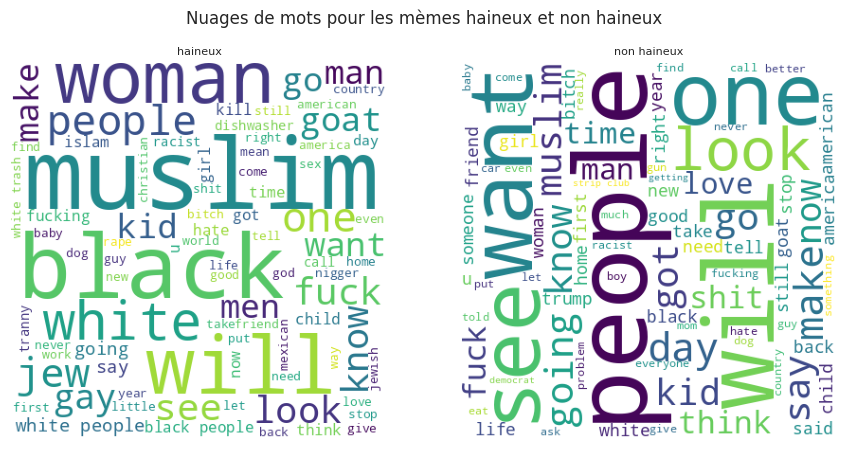

In [57]:
word_cloud(hateful_clean, not_hateful_clean)

On remarque que les mots qui reviennent le plus souvents sont assez différents selon que le mème soit haineux ou non. Pour mieux visualiser les résulats, nous avons réalisé une fonction nous permettant de voir quels étaient les  mots les plus utilisés et les mots les moins utilisés pour chaque catégorie de mèmes. 

In [58]:
def occurence(texte):  # fonction qui compte les mots
    if isinstance(texte, list): # vérifier si texte est une liste
        texte = ' '.join(texte) # concaténer les éléments de la liste en une chaîne de caractères
    texte = texte.split()
    return pd.Series(texte).value_counts()


In [70]:
occurence("je suis suis suis juliette")

suis        3
je          1
juliette    1
dtype: int64

In [59]:
def compte(data_set_1):
    compte = data_set_1["text"].apply(occurence)
    compte = compte.fillna(0)
    compte = compte.sum().sort_values(ascending=False) # trier les valeurs par ordre décroissant
    compte = pd.DataFrame({'Word':compte.index, 'Occurence':compte.values})
    return (compte)


In [60]:
compte_hateful = compte(hateful_clean)
compte_hateful

<ipython-input-58-a4c23d46d9f6>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(texte).value_counts()
<ipython-input-58-a4c23d46d9f6>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(texte).value_counts()


,Word,Occurence
0,muslim,292.0
1,black,278.0
2,people,276.0
3,white,242.0
4,will,170.0
...,...,...
4959,attic,1.0
4960,seattle,1.0
4961,unattended,1.0
4962,imitate,1.0


In [68]:
compte_not_hateful = compte(not_hateful_clean)
compte_not_hateful

<ipython-input-58-a4c23d46d9f6>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(texte).value_counts()
<ipython-input-58-a4c23d46d9f6>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(texte).value_counts()
<ipython-input-58-a4c23d46d9f6>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(texte).value_counts()
<ipython-input-58-a4c23d46d9f6>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(texte).value_counts()
<ipython-input-58-a4c23d46d9f6>:5: FutureWarning: Th

,Word,Occurence
0,people,297.0
1,will,241.0
2,one,189.0
3,want,180.0
4,make,166.0
...,...,...
6371,whichhunt,1.0
6372,kellogs,1.0
6373,contries,1.0
6374,porkistan,1.0


## Mots en commun 

In [73]:
def common_words_percentage(df1, df2):
    # On calcule le nombre total de mots uniques dans chaque DataFrame
    total_df1 =len(df1)
    total_df2 = len(df2)

    # On récupère les mots en commun entre les deux DataFrames
    common_words_df = pd.merge(df1, df2, on='Word', how='inner')
    
    # On calcule le nombre total de mots en commun
    total_common_words = len(common_words_df)

    # On calcule les pourcentages de mots en commun
    pct_common1 = (total_common_words / total_df1) * 100
    pct_common2 = (total_common_words / total_df2) * 100
    
    return pct_common1, pct_common2

In [74]:
common_words_percentage(compte_hateful, compte_not_hateful)

(67.70749395648672, 52.71329987452948)

67,7% des mots utilisés dans les mèmes haineux sont aussi utilisés dans les mèmes non haineux. De plus, 52,7% des mots utilisés dans les mèmes non haineux sont aussi utilisés dans les mème haineux. 

In [75]:
def top_common_words(df1, df2, n):
    # On récupère les mots en commun entre les deux DataFrames
    common_words_data = pd.merge(df1, df2, on='Word', how='inner')
    name_1 = get_df_name(df1)
    name_2 = get_df_name(df2)
    common_words_data = common_words_data.rename(columns={'Occurence_x': 'Occurence_'+name_1})
    common_words_data = common_words_data.rename(columns={'Occurence_y': 'Occurence_'+name_2})
    
    
    # On trie les mots en commun par ordre décroissant d'occurrences et on prend les n premiers
    top_common_words_df = common_words_data.sort_values(by='Occurence_'+name_1, ascending=False).head(n)
    
    return top_common_words_df

In [76]:
top_common_words(compte_hateful, compte_not_hateful, 20)

,Word,Occurence_compte_hateful,Occurence_compte_not_hateful
0,muslim,292.0,142.0
1,black,278.0,131.0
2,people,276.0,297.0
3,white,242.0,136.0
4,will,170.0,241.0
5,woman,155.0,72.0
6,one,137.0,189.0
7,jew,134.0,25.0
8,kill,103.0,73.0
9,see,101.0,160.0


Ce tableau trie les mots par ordre décroissant quant au nombre d'occurence pour la base "hateful" en donnant en plus le nombre d'occurence pour la base "not hateful". 

In [77]:
top_common_words(compte_not_hateful, compte_hateful, 20)

,Word,Occurence_compte_not_hateful,Occurence_compte_hateful
0,people,297.0,276.0
1,will,241.0,170.0
2,one,189.0,137.0
3,want,180.0,96.0
4,make,166.0,87.0
5,look,164.0,92.0
6,see,160.0,101.0
7,day,159.0,57.0
8,time,156.0,83.0
9,go,143.0,77.0


Ce tableau trie les mots par ordre décroissant quant au nombre d'occurence pour la base "not hateful" en donnant en plus le nombre d'occurence pour la base "hateful".